In [1]:
def plot_sed(x, y, yerr):
    plt.clf()
    plt.errorbar(wavelength, flux, yerr=flux_err, c='red', ecolor='gray', capthick=2)
    plt.show()

# Libraries

In [2]:
# usual libraries ----------------------------------------------------------------------------------------------------
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import astropy.io.fits   as pf
import astropy.constants as ct
import os
import time
import scipy.interpolate as sci

In [3]:
# ppxf separately ----------------------------------------------------------------------------------------------------
import ppxf.miles_util   as lib  # MILES library embedded in ppxf
import ppxf.ppxf_util    as util
import ppxf              as ppxf_module
from ppxf.ppxf           import ppxf
from ppxf.ppxf_util      import log_rebin

# Dataset

In [4]:
dataset_path = './../../Catalogue/Match08_smallemlines_inputcattype.csv'
my_data      = pd.read_csv(dataset_path)

In [5]:
whan_class = my_data['WHAN_CLASS'].values.astype(str)
uv_class   = my_data['UV_CLASS_YI2011'].values.astype(str)
cataid     = my_data['CATAID'].values.astype(str)
specid     = my_data['SPECID'].values.astype(str)
s2n        = my_data['S2N'].values.astype(float)
chi2_gama  = my_data['CHI2'].values.astype(float)
redshift   = my_data['Z'].values.astype(float)

In [6]:
uv_unique   = np.unique(uv_class, return_counts=True)
whan_unique = np.unique(whan_class, return_counts=True)
print (uv_unique, '\n', whan_unique)

(array(['RSF', 'UV_UPTURN', 'UV_WEAK'], dtype='<U9'), array([13840,   210,   296])) 
 (array(['Retired/Passive', 'SF', 'nan', 'sAGN', 'wAGN'], dtype='<U15'), array([ 876, 9408, 1285, 2184,  593]))


In [7]:
idx_uvup_rp = np.where((uv_class=='UV_UPTURN')*(whan_class=='Retired/Passive'))

## Plot the distributions of S/N

### Plot settings (yes, I'm lazy)

In [8]:
bins = 20
palette = ['#a6611a','#dfc27d','#80cdc1','#018571']
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.

### Histogram - S/N and $\chi^2$

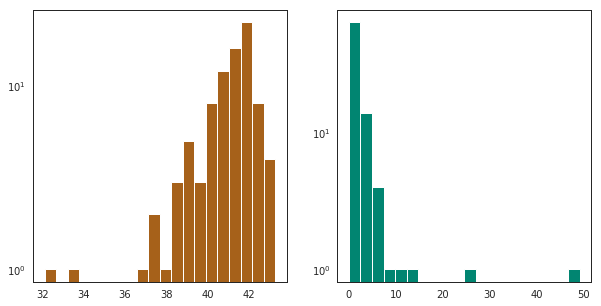

In [9]:
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(s2n[idx_uvup_rp], bins=bins, color=palette[0])
plt.yscale('log')
plt.subplot(1,2,2)
plt.hist(chi2_gama[idx_uvup_rp], bins=bins, color=palette[3])
plt.yscale('log')
plt.show()

### Selecting top 10 objects with the best S2N

In [10]:
best_s2n_10 = np.argsort(s2n[idx_uvup_rp])[-10:-1]

In [11]:
s2n_top10 = s2n[idx_uvup_rp][best_s2n_10]    # top 10 objects given the S/N

In [12]:
chi2_top   = chi2_gama[idx_uvup_rp][best_s2n_10]
specid_top = specid[idx_uvup_rp][best_s2n_10]

# pPXF

## Configuring inputs

In [13]:
ppxf_dir     = os.path.dirname(os.path.realpath(ppxf_module.__file__))
miles_lib    = ppxf_dir+'/miles_models/Mun1.30*.fits'
seds_path   = './../../../../GAMADR3_SPECTRA/DATABASE/'
results_path = './Results/'

light_speed  = float(str(ct.c.to('km/s')).split(' ')[0])            # selecting the numerical values (must be in km/s)

In [14]:
seds_list = []
for i in specid_top: seds_list.append(i+'.fit')

### pPXF plot settings

In [15]:
palette      = ['#ef8a62','#f7f7f7','#67a9cf']
transparency = 0.8
lw           = 2.

## pPXF settings

In [16]:
# Fit (V, sig, h3, h4) moments=4 for the stars; (V, sig) moments=2 for the two gas kinematic components
moments        = [4, 2, 2]
degree         = -1         # Additive Legendre polynomial degrees
mdegree        = 200        # Multiplicative Legendre polynomial degrees
regul_err      = 0.013      # Desired regularization error -- TODO: MUST CHECK WHY
tied_balmer    = True
limit_doublets = False
stellar_comp_w = [0]        # weight of the stellar component
balmer_comp_w  = [1]        # weight of the balmer emission lines
forbid_comp_w  = [2]        # weight of the forbidden lines
wl_min         = 3540       # MILES RANGE MIN
wl_max         = 7409       # MILES RANGE MAX
# wl_min = 4000
# wl_max = 7409

In [17]:
mean_age   = ['<logAge>']
mean_metal = ['<[M/H]>']
mass2light = ['MASS2LIGHT_R']
ids        = ['CATAID']
redshifts  = ['Z']

/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     49673       556    -0.161     0.300
 comp. 1:     49765      1000
 comp. 2:     49800       180
chi2/DOF: 0.004646
method = capfit ; Jac calls: 12 ; Func calls: 2526 ; Status: 2
Gas Reddening E(B-V): 4.073
Nonzero Templates:  68  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      51.01       5.7   49765  1000
Comp: 2       Unknown          0       5.5   49800   180
Comp: 2       Unknown          0       5.4   49800   180
Comp: 2       Unknown          0       3.1   49800   180
---------------------------------------------------------
Weighted <logAge> [yr]: 9.9
Weighted <[M/H]>: -0.195
Weighted <logAge> [yr]: 9.9
Weighted <[M/H]>: -0.195
M/L_r: 3.255
Current $\chi^2$: 0.0046
Elap

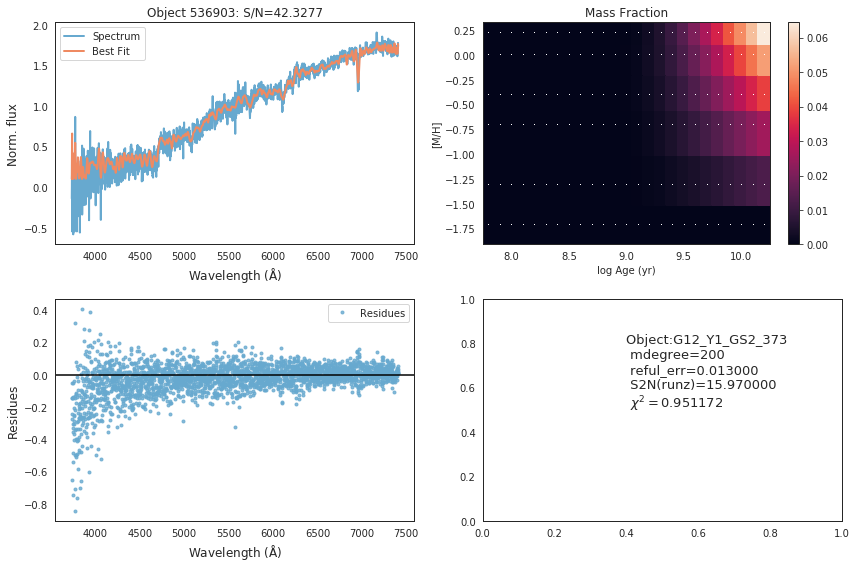

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     57580       962    -0.090     0.102
 comp. 1:     56456         2
 comp. 2:     56812       180
chi2/DOF: 0.004616
method = capfit ; Jac calls: 26 ; Func calls: 5465 ; Status: 2
Gas Reddening E(B-V): 2.836
Nonzero Templates:  76  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.2735       2.1   56456     2
Comp: 2       Unknown          0       5.1   56812   180
Comp: 2       Unknown          0       5.1   56812   180
Comp: 2       Unknown          0       2.9   56812   180
---------------------------------------------------------
Weighted <logAge> [yr]: 9.87
Weighted <[M/H]>: -0.195
Weighted <logAge> [yr]: 9.87
Weighted <[M/H]>: -0.195
M/L_r: 2.945
Current $\chi^2$: 0.0046
El

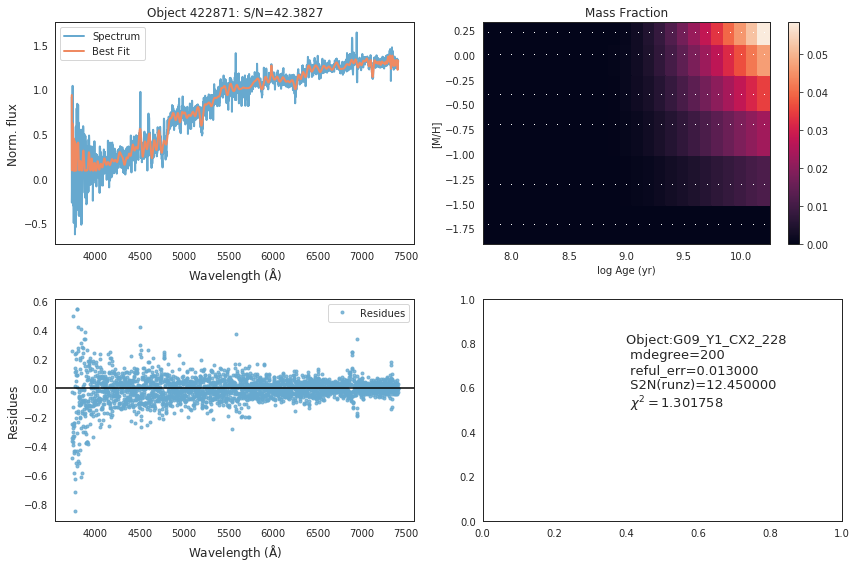

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     51719      1000     0.012     0.104
 comp. 1:     51986       212
 comp. 2:     51555       155
chi2/DOF: 0.02147
method = capfit ; Jac calls: 31 ; Func calls: 6515 ; Status: 2
Gas Reddening E(B-V): 0.302
Nonzero Templates:  144  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      7.875       3.1   51986   212
Comp: 2       Unknown     0.3166         7   51555   155
Comp: 2       Unknown     0.4743       6.9   51555   155
Comp: 2       Unknown     0.8447       2.3   51555   155
---------------------------------------------------------
Weighted <logAge> [yr]: 9.78
Weighted <[M/H]>: -0.632
Weighted <logAge> [yr]: 9.78
Weighted <[M/H]>: -0.632
M/L_r: 1.788
Current $\chi^2$: 0.0215
El

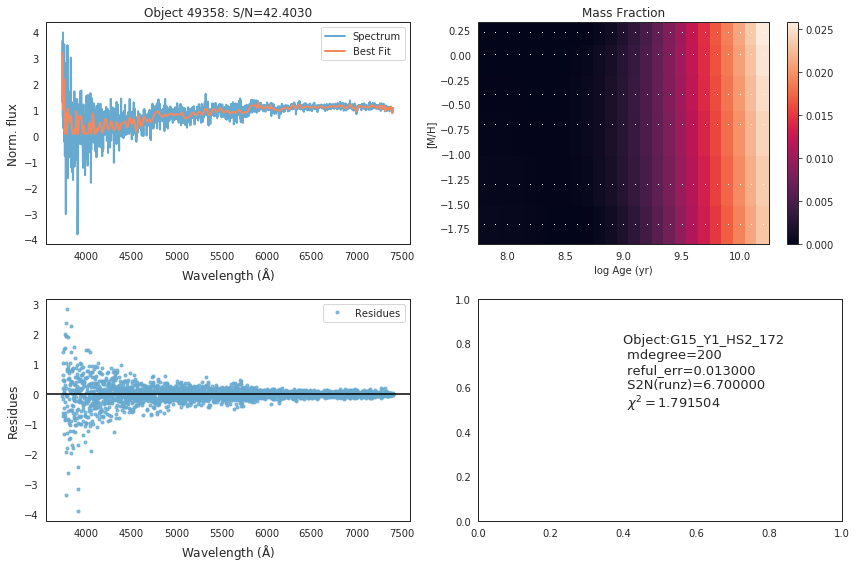

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     69353       925     0.111     0.210
 comp. 1:     69778       269
 comp. 2:     69681       200
chi2/DOF: 0.00815
method = capfit ; Jac calls: 10 ; Func calls: 2105 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  90  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      2.444        10   69778   269
Comp: 2       Unknown          0       5.2   69681   200
Comp: 2       Unknown     0.5462       5.2   69681   200
Comp: 2       Unknown      1.286       3.1   69681   200
---------------------------------------------------------
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.196
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.196
M/L_r: 2.677
Current $\chi^2$: 0.0081
Ela

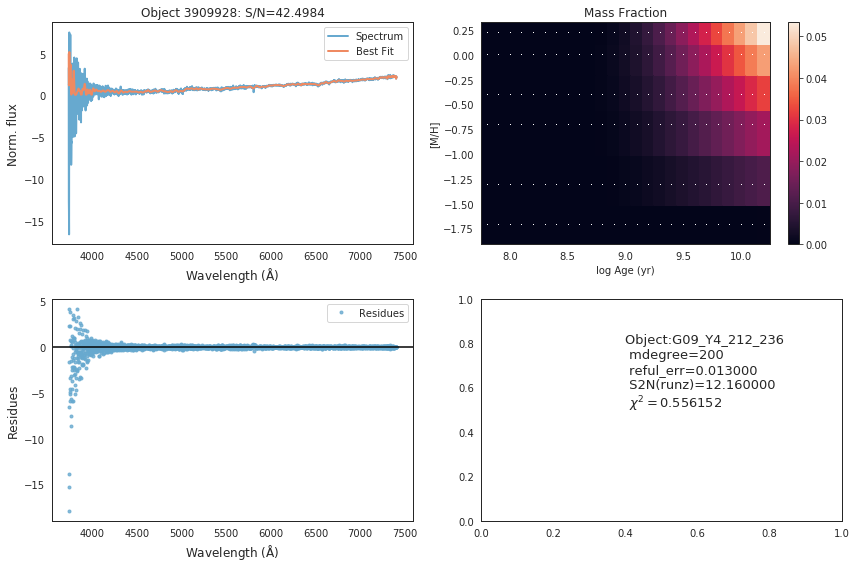

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     55415      1000     0.054     0.021
 comp. 1:     55047         1
 comp. 2:     54977         1
chi2/DOF: 0.0108
method = capfit ; Jac calls: 14 ; Func calls: 2944 ; Status: 2
Gas Reddening E(B-V): 4.171
Nonzero Templates:  101  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown          0       1.9   55047     1
Comp: 2       Unknown          0       2.5   54977     1
Comp: 2       Unknown     0.6161       2.6   54977     1
Comp: 2       Unknown          0       1.9   54977     1
---------------------------------------------------------
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.234
Weighted <logAge> [yr]: 9.8
Weighted <[M/H]>: -0.234
M/L_r: 2.413
Current $\chi^2$: 0.0108
Elaps

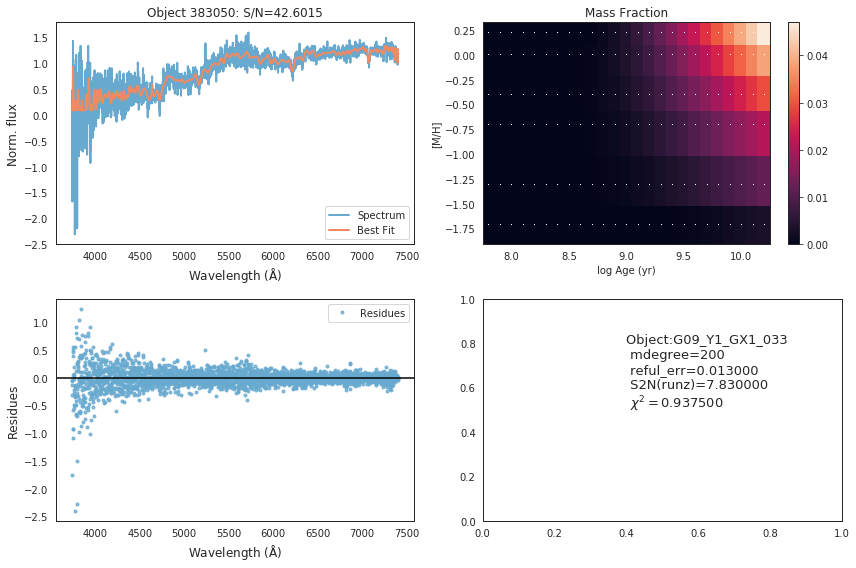

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     43303       914     0.104     0.115
 comp. 1:     43353       418
 comp. 2:     42690       706
chi2/DOF: 0.002736
method = capfit ; Jac calls: 23 ; Func calls: 4836 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  141  /  155
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      9.847       4.9   43353   418
Comp: 2       Unknown          0        38   42690   706
Comp: 2       Unknown      6.738        37   42690   706
Comp: 2       Unknown      1.476       6.6   42690   706
Comp: 2       Unknown      9.146         4   42690   706
---------------------------------------------------------
Weighted <logAge> [yr]: 8.81
Weighted <[M/H]>: -1.04
Weighted <logAge> [yr]: 

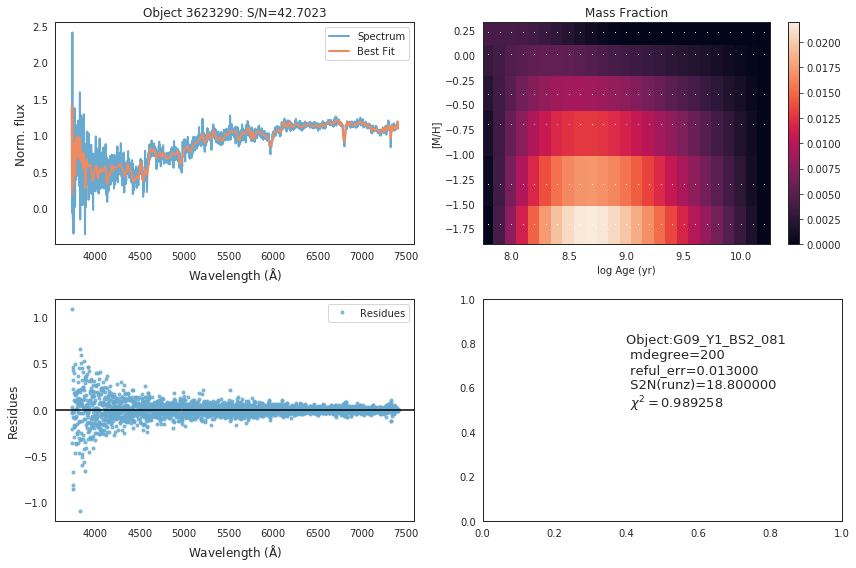

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d' '[OI]6300_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     47482       535    -0.025     0.300
 comp. 1:     47667      1000
 comp. 2:     47646       258
chi2/DOF: 0.003178
method = capfit ; Jac calls: 13 ; Func calls: 2735 ; Status: 2
Gas Reddening E(B-V): 3.719
Nonzero Templates:  76  /  155
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown      68.81        11   47667  1000
Comp: 2       Unknown          0       6.2   47646   258
Comp: 2       Unknown          0       6.3   47646   258
Comp: 2       Unknown      0.215       3.9   47646   258
Comp: 2       Unknown          0       5.3   47646   258
---------------------------------------------------------
Weighted <logAge> [yr]: 9.88
Weighted <[M/H]>: -0.196
Weighted <logAge> [yr]: 

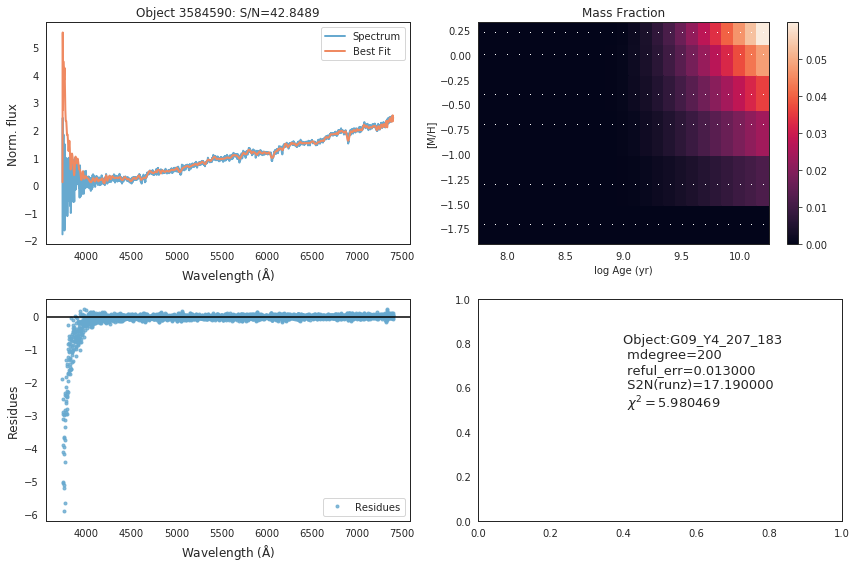

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     57862       847    -0.011     0.257
 comp. 1:     57969       658
 comp. 2:     58857        52
chi2/DOF: 0.01734
method = capfit ; Jac calls: 13 ; Func calls: 2736 ; Status: 2
Gas Reddening E(B-V): 0.092
Nonzero Templates:  147  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown       22.9        16   57969   658
Comp: 2       Unknown  0.0004107       3.2   58857    52
Comp: 2       Unknown     0.1115       3.2   58857    52
Comp: 2       Unknown     0.3084         2   58857    52
---------------------------------------------------------
Weighted <logAge> [yr]: 9.63
Weighted <[M/H]>: -0.228
Weighted <logAge> [yr]: 9.63
Weighted <[M/H]>: -0.228
M/L_r: 1.281
Current $\chi^2$: 0.0173
El

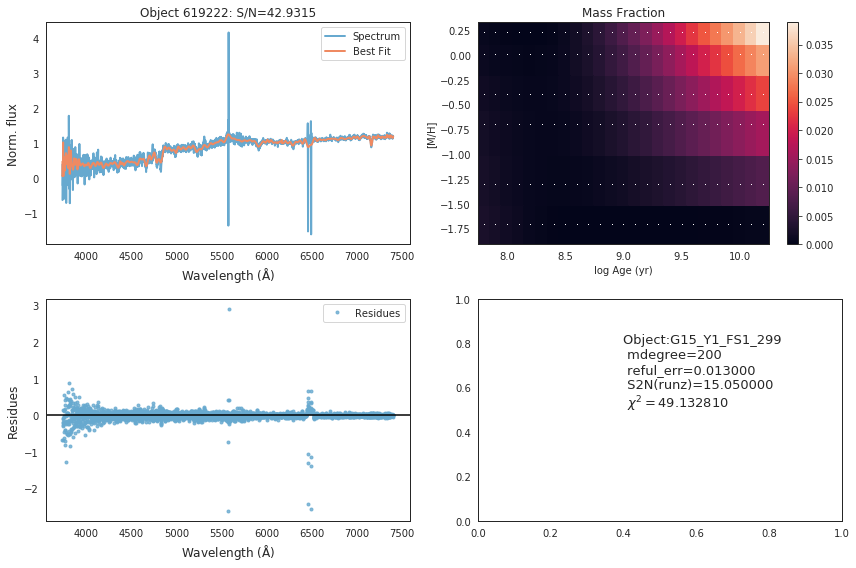

Emission lines included in gas templates:
['Balmer' '[OII]3726' '[OII]3729' '[OIII]5007_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:     53314       868    -0.136     0.194
 comp. 1:     53258       203
 comp. 2:     54202         1
chi2/DOF: 0.003058
method = capfit ; Jac calls: 13 ; Func calls: 2735 ; Status: 2
Gas Reddening E(B-V): 0.000
Nonzero Templates:  91  /  154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1       Unknown     0.6882       5.6   53258   203
Comp: 2       Unknown     0.0259       2.3   54202     1
Comp: 2       Unknown     0.3242       2.3   54202     1
Comp: 2       Unknown     0.1744       1.9   54202     1
---------------------------------------------------------
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.198
Weighted <logAge> [yr]: 9.83
Weighted <[M/H]>: -0.198
M/L_r: 2.686
Current $\chi^2$: 0.0031
El

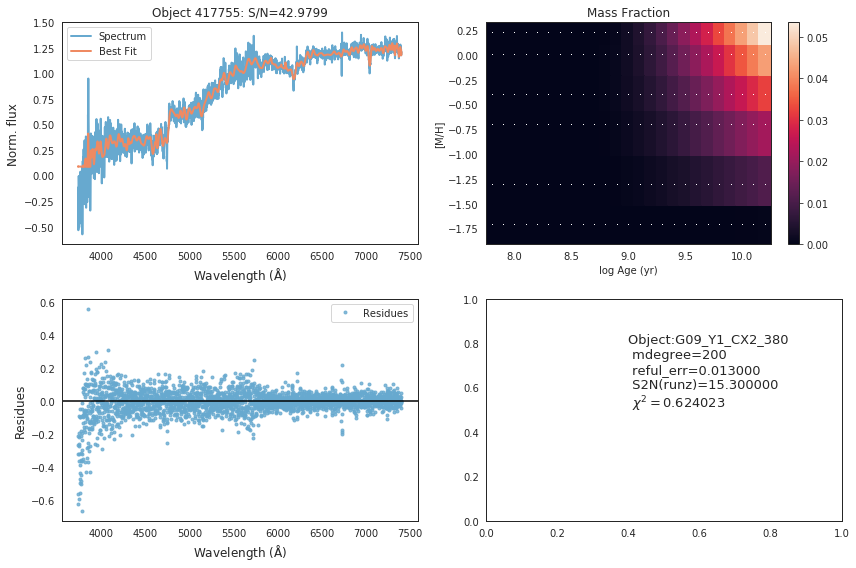

In [18]:
for each_sed in range(len(seds_list)):
    # flux -----------------------------------------------------------------------------------------------------------
    sed_file  = os.path.join(seds_path, seds_list[each_sed])          # link between path and files
    sed_flux  = pf.getdata(sed_file)[0]                               # opening each spectra
    sed_err   = pf.getdata(sed_file)[1]                               # opening each spectra error
    
    # wavelength -----------------------------------------------------------------------------------------------------
    sed_header = pf.open(sed_file)[0].header
    sed_wl_ini = sed_header['WMIN'] 
    sed_wl_stp = sed_header['CD1_1']
    sed_wl     = np.arange(sed_flux.size)*(sed_wl_stp)+sed_wl_ini     # sed wavelength
    
#     plot_sed(sed_wl, sed_flux, sed_err)
    
    # cleaning flux and wavelength trash -----------------------------------------------------------------------------
    idx_clean       = np.where((np.logical_not(np.isnan(sed_flux)))*(sed_err>0))    # indices where NAN is present
    flux_temp       = sed_flux[idx_clean]                                           # removing NAN values from spectra
    flux_temp_err   = sed_err[idx_clean]
    wavelength_temp = sed_wl[idx_clean]
    
#     plot_sed(wavelength_temp, flux_temp, flux_temp_err)
    
    # limiting the spectrum regarding the wavelength range of the library --------------------------------------------
    wl_lib_idx = (wavelength_temp>wl_min) & (wavelength_temp<wl_max)       # MILES wavelength range
    flux       = flux_temp[wl_lib_idx]
    flux_err   = flux_temp_err[wl_lib_idx]
    wavelength = wavelength_temp[wl_lib_idx]
    
#     plot_sed(wavelength, flux, flux_err)    
    
    # other important parameters -------------------------------------------------------------------------------------
    redshift  = sed_header['Z']
    cataid    = sed_header['CATAID']
    fwhm_gama = 3.
    
    # ppxf -----------------------------------------------------------------------------------------------------------
    vel_scale          = light_speed*np.log(wavelength[1]/wavelength[0])      # velocity scale - Eq.8 Capellari 2017
    
    ### setup templates ----------------------------------------------------------------------------------------------
    #### stellar pops ------------------------------------------------------------------------------------------------
    miles              = lib.miles(miles_lib, vel_scale, fwhm_gama)
    stellar_templates  = miles.templates.reshape(miles.templates.shape[0], -1)
    reg_dim            = miles.templates.shape[1:]
    dv                 = light_speed*(miles.log_lam_temp[0] - np.log(wavelength[0]))  # eq.(8) of Cappellari (2017)
    vel                = light_speed*np.log(1 + redshift)                             # eq.(8) of Cappellari (2017)
    start              = [vel, 180.]
    
    #### gas templates -----------------------------------------------------------------------------------------------
    wl_range_galaxy = np.array([np.min(wavelength), np.max(wavelength)])/(1 + redshift)
    gas_templates, gas_names, line_wave = util.emission_lines(miles.log_lam_temp, wl_range_galaxy, fwhm_gama, 
                                                              tie_balmer=tied_balmer, limit_doublets=limit_doublets)
    number_of_templates = stellar_templates.shape[1]
    number_of_forbidden = np.sum(["[" in a for a in gas_names])                      # forbidden lines contain "[*]"
    number_of_balmer    = len(gas_names) - number_of_forbidden
        
    component = (stellar_comp_w*number_of_templates)+(balmer_comp_w*number_of_balmer)+(forbid_comp_w
                                                                                       *number_of_forbidden)
        
    gas_component = np.array(component) > 0       # gas_component=True for gas templates
    start3        = [start, start, start]         # adopt the same starting value for the 3 components
    gas_reddening = 0 if tied_balmer else None    # If the Balmer lines are tied one should allow for gas reddening.
    
    
    #### all templates -----------------------------------------------------------------------------------------------
    all_templates = np.column_stack([stellar_templates, gas_templates])
    
    ### rebinning the spectrum so it is at the same size as the templates (or smaller) -------------------------------
    new_shape          = stellar_templates[:,0].shape
    rebinning_function = sci.interp1d(wavelength, flux)   # for the flux
    wavelength_rebin   = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_rebin         = rebinning_function(wavelength_rebin)
    
    ### rebinning the error ------------------------------------------------------------------------------------------
    rebin_func_error   = sci.interp1d(wavelength, flux_err)
    wl_rebin_error     = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_err_rebin     = rebin_func_error(wavelength_rebin)
    
    ### final galaxy spectrum and its error to be analysed -----------------------------------------------------------
    galaxy             = flux_rebin/np.median(flux_rebin)               # Normalize spectrum to avoid numerical issues
    noise              = flux_err_rebin/np.median(flux_err_rebin)       # idem
    
#     plot_sed(wavelength_rebin, galaxy, noise)
    
    
    ### SED FITTING WITH PPXF ----------------------------------------------------------------------------------------
    start_time = time.clock()
    sed_fit = ppxf(templates=all_templates, galaxy=galaxy, noise=noise, velscale=vel_scale, start=start3, plot=False, 
                   lam=wavelength_rebin, moments=moments, degree=degree, mdegree=mdegree, regul=1./regul_err, 
                   reg_dim=reg_dim, vsyst=dv, clean=False, component=component, gas_component=gas_component,
                   gas_reddening=gas_reddening)
    end_time = time.clock()
    
    ## output parameters -- most of them will become a dataframe at the end of the script  
    residues = (galaxy-sed_fit.bestfit)
    
    stellar_weights = sed_fit.weights[~gas_component]                         # Exclude weights of the gas templates
    stellar_weights = stellar_weights.reshape(reg_dim)/stellar_weights.sum()  # Normalized
    
    mean_age.append(miles.mean_age_metal(stellar_weights)[0])
    mean_metal.append(miles.mean_age_metal(stellar_weights)[1])
    mass2light.append(miles.mass_to_light(stellar_weights, band="r"))
    ids.append(cataid)
    redshifts.append(redshift)
       
    print(r"Current $\chi^2$: %.4f" % (sed_fit.chi2))
    print('Elapsed time in PPXF: %.2f [min]' % ((end_time-start_time)/60))
    
    ### Saving fit results -------------------------------------------------------------------------------------------
    output = {}
    output['wavelength'] = wavelength_rebin
    output['flux']       = sed_fit.galaxy
    output['best_fit']   = sed_fit.bestfit
    
    output_df = pd.DataFrame(output)
    output_df.to_csv(os.path.join('./Results/', 'fit_'+str(cataid)+'_'+str(mdegree)+str(wl_min)+'.csv'), index=False)

    ### Saving plots -------------------------------------------------------------------------------------------------
    plt.subplots(figsize=(12,8))
    
    #### plot01 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,1)
    plt.plot(wavelength_rebin, sed_fit.galaxy, '-', color=palette[-1], linewidth=lw, label="Spectrum")
    plt.plot(wavelength_rebin, sed_fit.bestfit, '-', color=palette[0], linewidth=lw, label="Best Fit")
    plt.title("Object %s: S/N=%.4f" % (cataid, s2n_top10[each_sed]))
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Norm. flux", fontsize=12)
    
    #### plot02 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,2)
    miles.plot(stellar_weights)
    
    #### plot03 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,3)
    plt.plot(wavelength_rebin, residues, '.', color=palette[-1], linewidth=lw, label="Residues", alpha=transparency)
    plt.axhline(y=0, c='black')
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Residues", fontsize=12)
    
    #### plot04 ------------------------------------------------------------------------------------------------------
    plt.subplot(2,2,4)
    plt.text(0.4, 0.5, "Object:{:s} \n mdegree={:d} \n reful_err={:f} \n S2N(runz)={:f} \n $\chi^2=${:f}".
             format(sed_header['SPECID'], mdegree, regul_err, sed_header['SN'], chi2_top[each_sed]), fontsize=13)
    
    plt.tight_layout()
    plt.savefig(os.path.join('./Results/', 'gal_'+str(cataid)+'_'+str(mdegree)+str(wl_min)+'.png'))
    plt.show()

In [19]:
### Saving outputs as dataframe ----------------------------------------------------------------------------------
ids        = np.array(ids)
redshifts  = np.array(redshifts)
mean_age   = np.array(mean_age)
mean_metal = np.array(mean_metal)
mass2light = np.array(mass2light)
outputs    = np.column_stack((ids, redshifts, mean_age, mean_metal, mass2light))
columns    = outputs[0,:]
outputs_dataframe = pd.DataFrame(outputs[1:,:])
outputs_dataframe.columns = columns
outputs_dataframe.to_csv('./Results/'+'ouputs_ppxf_'+mdegree+'_'+wl_min+'.csv', index=False)

In [20]:
!cp ./Results/ouputs_ppxf.csv ./Results/outputs_ppxf_200.csv